In [24]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%autoreload 
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import utilities as ut
import plotly.express as px

In [26]:
h2o.init(max_mem_size='13G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,4 hours 17 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_henrikraa_mn6o67
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,9.96 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


## Load models

In [27]:
xgb_model = h2o.load_model('h20_models/1027_h_xgboost_model_build_BC_feng_means')
stacked_model = h2o.load_model('h20_models/1027_h_ensaemble_model_build_BC_feng_means')

### Predict

In [28]:
X_test = pd.read_csv('training_data/hourly_mean/X_test_selected_BC.csv')
X_test = X_test.set_index('date_forecast')
X_test.index = pd.to_datetime(X_test.index)
X_test_h2o = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [29]:
# predict using the two models
preds_stacked = stacked_model.predict(X_test_h2o)
preds_stacked_df = preds_stacked.as_data_frame()
preds_stacked_df.index = X_test.index
# cnvert the index to datetime
preds_stacked_df.index = pd.to_datetime(preds_stacked_df.index)

preds_xgb = xgb_model.predict(X_test_h2o)
preds_xgb_df = preds_xgb.as_data_frame()
preds_xgb_df.index = X_test.index
# cnvert the index to datetime
preds_xgb_df.index = pd.to_datetime(preds_xgb_df.index)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [30]:
# remove all the negative values in the predictions and replace them with 0
preds_stacked_df[preds_stacked_df < 0] = 0
# filter it so it oly contains pv_measurement for whole hours  
preds_stacked_df = preds_stacked_df[preds_stacked_df.index.minute == 0]

# remove all the negative values in the predictions and replace them with 0
preds_xgb_df[preds_xgb_df < 0] = 0
# filter it so it oly contains pv_measurement for whole hours
preds_xgb_df = preds_xgb_df[preds_xgb_df.index.minute == 0]

<Axes: xlabel='date_forecast'>

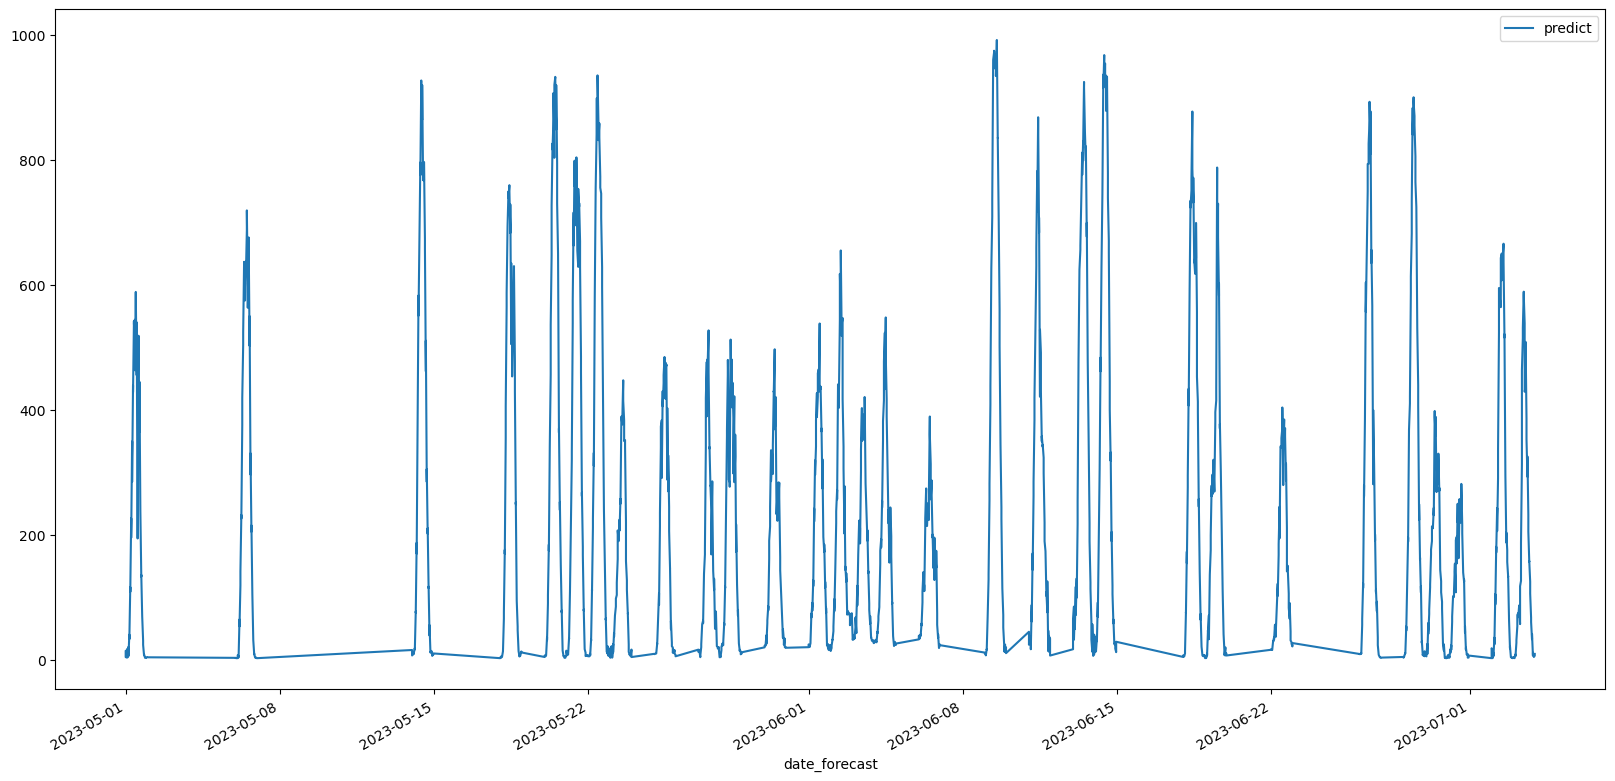

In [31]:
preds_stacked_df.plot(figsize=(20,10))

<Axes: xlabel='date_forecast'>

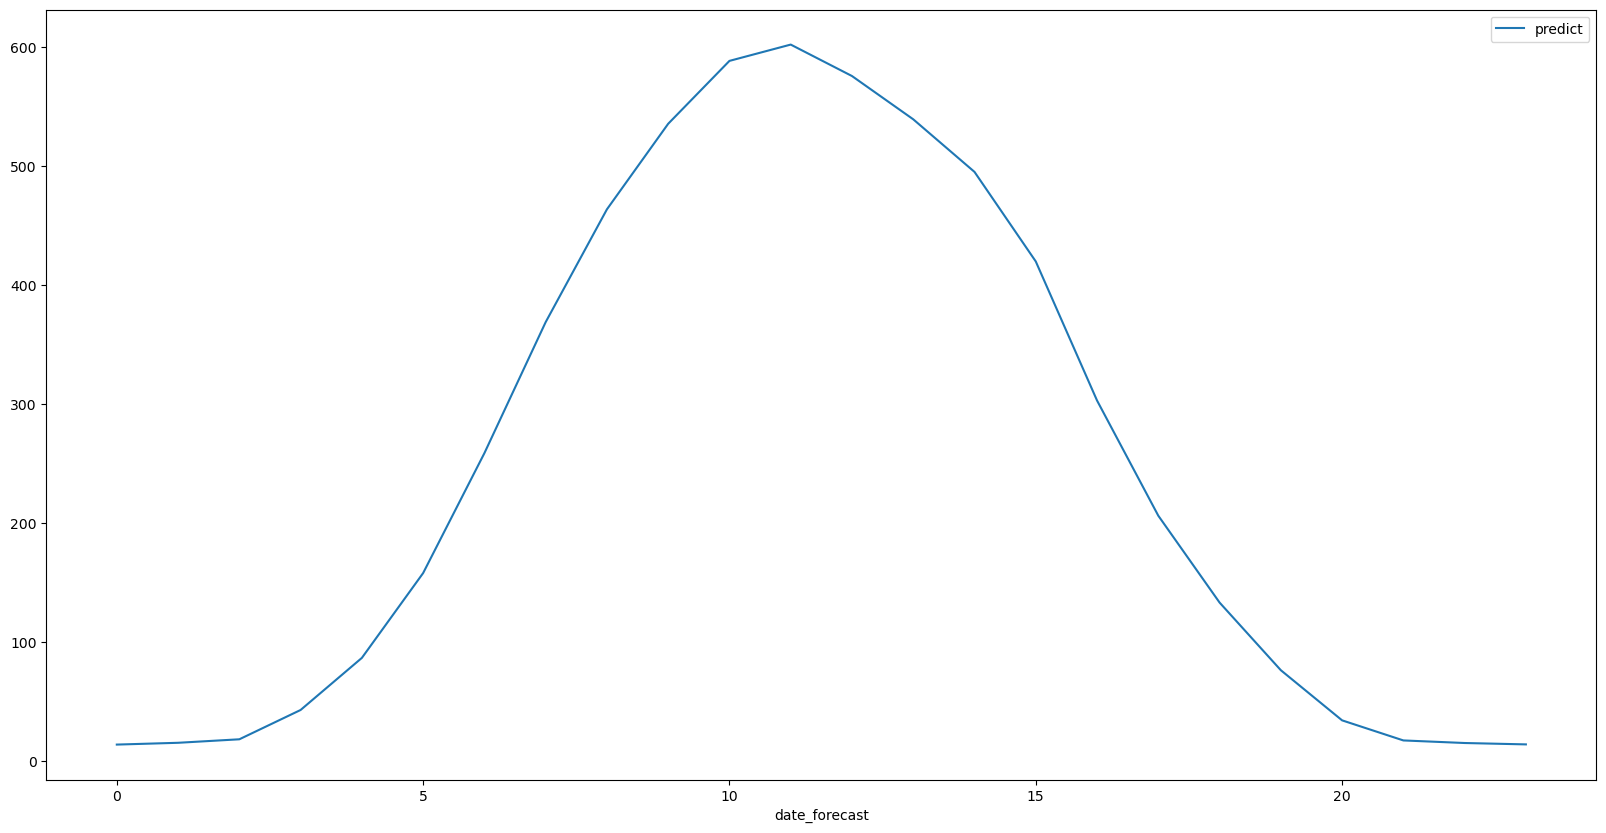

In [32]:
# show the pv_prediction average dsiutribution per hour
preds_stacked_df.groupby(preds_stacked_df.index.hour).mean().plot(figsize=(20,10))

In [33]:
# reset the index and remove the date_forecast column
preds_stacked_df = preds_stacked_df.reset_index()
preds_stacked_df = preds_stacked_df.drop(['date_forecast'], axis=1)
preds_stacked_df.columns = ['pv_prediction']
# save the predictions
preds_stacked_df.to_csv('h2o_predictions/1027_h_ensaemble_model_build_BC_feng_means.csv')

preds_xgb_df = preds_xgb_df.reset_index()
preds_xgb_df = preds_xgb_df.drop(['date_forecast'], axis=1)
preds_xgb_df.columns = ['pv_prediction']
# save the predictions
preds_xgb_df.to_csv('h2o_predictions/1027_h_xgboost_model_build_BC_feng_means.csv')